In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 580)

import os
from datetime import datetime
from datetime import timedelta  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statistics as sts
import seaborn as sns
import time
from matplotlib import rcParams
import math
import pickle
import sklearn
import multiprocessing as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

from scipy.stats import uniform, randint, normaltest
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, cross_val_predict,StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import ComplementNB,MultinomialNB,BernoulliNB,GaussianNB
#import h2o
#from h2o.automl import H2OAutoML
from sklearn import svm
from sklearn import metrics

from datetime import datetime
import datetime

C:\Users\svera\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\svera\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\svera\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in

In [2]:
def get_metricas(TEST_y, predicciones_test):

    AUC = round(metrics.roc_auc_score(TEST_y, predicciones_test), 3)
    ac = round(sklearn.metrics.accuracy_score(TEST_y, predicciones_test), 3)
    mcc = round(sklearn.metrics.matthews_corrcoef(TEST_y, predicciones_test), 3)
    rec = round(sklearn.metrics.recall_score(TEST_y, predicciones_test), 3)
    
    print("Recall: " + str(rec))
    print("Accuracy: " + str(ac))
    print("AUC: " + str(AUC))
    print("Matthews correlation coefficient: " + str(mcc))

In [3]:
def cvxgboost(x, y, xgb_model):
    
    kf = KFold(n_splits=8, shuffle=True, random_state=2)
    dictXG={}
    k=0
    xP=x

    for train_index, test_index in kf.split(xP):

        dictTemp={}
        X_train, X_test = xP[train_index], xP[test_index]
        Y_train, Y_test = y[train_index], y[test_index]

        #X_train, Y_train = sm.fit_sample(X_train, Y_train.ravel())

        xgb_model.fit(X_train, Y_train)
        predicted=xgb_model.predict(X_test)

        rec= sklearn.metrics.recall_score(Y_test, predicted)
        ac= sklearn.metrics.accuracy_score(Y_test, predicted)
        auc = metrics.roc_auc_score(Y_test, predicted)
        mcc = round(sklearn.metrics.matthews_corrcoef(TEST_y, predicciones_test), 3)

        dictTemp["Accuracy"]=ac
        dictTemp["Recall"]=rec
        dictTemp["AUC"]=auc
        dictTemp["MCC"] = mcc

        dictXG[k]=dictTemp
        k=k+1 
        
    return pd.DataFrame(dictXG).transpose()

In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
# Dejar home delivery como la opcion a setear
# Filtrar por Santiago

In [5]:
df = pd.read_csv('nivel_servicio_logistica_abril.csv', sep='~', index_col=0)

C:\Users\svera\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (15,29,30,31,37,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

,DO_PICKING,ORDEN,ESTADO_CO,FECHA_CREACION,LOCAL_VENTA_DESC,SUBORDEN,ORIGEN_VENTA,SKU,ESTADO_LINEA,DO_PICKING_LINE_STATUS,RECALCULO_FECHA,CANTIDAD_ASIGNADA,FUENTE_SHIPPING,ABASTECIMIENTO,AGRUPACION_SALIDA,TAMAÑO_OMS,SKU_DESC,SKU_LINEA,SKU_SUBLINEA,SKU_CLASE,SKU_SUBCLASE,MARCA,TIPO_PRODUCTO,METODO_DESPACHO,FECHA_PACTADA,RANGO,RANGO_FECHA_PACTADA,FECHA_REPARTO,FECHA_ENTREGA,ESTADO_DO_TIENDA,RE_PROGRAMACION,RANGO_HORARIO,TIPO_DESPACHO,REGION_DESC,D_POSTAL_CODE,LOCALIDAD_DESC,TIENDA_DESTINO_DESC,FECHA_PICKING,LOCAL_REPART_DESC,ITEM,TRANSPORTISTA_PATENTE,TRANSPORTISTA,CUMPLIMIENTO,RECEPCION TEORICO,LLEGADA SISTEMA TEORICO,PLANIFICACION TEORICO,PICKING TEORICO,ADUANA TEORICO,SALIDA TEORICO,RECEPCION REAL,LLEGADA SISTEMA REAL,PLANIFICACION REAL,PICKING REAL,SALIDA REAL,RECEPCION CONDICION,LLEGADA SISTEMA CONDICION,PLANIFICACION CONDICION,PICKING CONDICION,ADUANA CONDICION,SALIDA CONDICION,Dias de Transito,Hora de salida,CUMPLIMIENTO2,OBSERVACION
0,121067352755,5384810153,Partially Released,2020-04-03 20:29:01,Venta a Distancia,144047143887,ATG,881417053,Allocated,Packed,N,2.0,CD Omnicanal LOF2,CD Omnicanal LOF2,9990,XS,R.ALLEN-TOA CPO MISTICA BCO,J12,J1202,J120201,J12020102,R.ALLEN,Producto,STS,2020-04-07 00:00:00,NaN,2020-04-07 00:00:00,2020-04-07 00:00:00,NaN,NaN,NaN,AD,Falabella,NaN,1047,NaN,(Tottus El Bosque) FALABELLA RETAIL S.A.,2020-04-04 23:59:00,(Tottus El Bosque) FALABELLA RETAIL S.A.,1,NaN,NaN,REVISAR,2020-04-04 22:00:00,2020-04-04 20:00:00,2020-04-04 22:00:00,2020-04-05 00:00:00,2020-04-05 02:00:00,2020-04-05 04:00:00,-,2020-04-03 20:32:48,2020-04-04 02:00:32,2020-04-04 05:15:03,-,ATRASO,-,-,-,-,ATRASO,2,04:00:00,CLIENTE,Cliente solicita NC
1,121070941205,5388692298,Allocated,2020-04-10 19:14:29,Venta a Distancia,144047752158,ATG,881345029,Allocated,Packed,N,1.0,CD Omnicanal LOF2,CD Omnicanal LOF2,9990,XS,MOUNTAIN-CALCETIN DEPORT 4PACK OUTD MELANGE ST,J03,J0303,J030301,J03030101,MOUNTAIN,Producto,STS,2020-04-22 00:00:00,NaN,2020-04-22 00:00:00,2020-04-22 00:00:00,NaN,NaN,NaN,AD,Falabella,REGION METROPOLITANA,1043,Tottus Nataniel,(Tottus Nataniel) FALABELLA RETAIL S.A.,2020-04-20 13:01:00,(Tottus Nataniel) FALABELLA RETAIL S.A.,1,NaN,NaN,REVISAR,2020-04-19 22:00:00,2020-04-19 20:00:00,2020-04-19 22:00:00,2020-04-20 00:00:00,2020-04-20 02:00:00,2020-04-20 04:00:00,-,2020-04-10 19:19:08,2020-04-20 00:08:58,2020-04-20 02:04:40,-,ATRASO,-,ATRASO,ATRASO,ATRASO,ATRASO,2,04:00:00,CLIENTE,Cliente-Cliente solicita NC
2,121061002793,5378005190,Partially DC Allocated,2020-03-20 10:29:07,Venta a Distancia,144046068572,ATG,881536525,Allocated,Packed,N,1.0,CD Omnicanal LOF2,CD Omnicanal LOF2,9990,XS,UNIVERSI-CUADRO BIKINI BMU1AV20 NAVY BLACK S,J06,J0601,J060102,J06010206,UNIVERSI,Producto,STS,2020-04-01 00:00:00,NaN,2020-04-01 00:00:00,2020-04-01 00:00:00,NaN,NaN,NaN,AD,Falabella,NaN,8147,NaN,(Tottus TrÃ©bol) FALABELLA RETAIL S.A.,2020-03-30 15:00:00,(Tottus TrÃ©bol) FALABELLA RETAIL S.A.,1,NaN,NaN,REVISAR,2020-03-29 17:00:00,2020-03-29 15:00:00,2020-03-29 17:00:00,2020-03-29 19:00:00,2020-03-29 21:00:00,2020-03-29 23:00:00,-,2020-03-20 10:29:48,2020-03-30 01:25:43,2020-03-30 09:49:34,-,ATRASO,-,ATRASO,ATRASO,ATRASO,ATRASO,3,23:00:00,CLIENTE,Cliente solicita NC
3,121064887939,5382287193,Allocated,2020-03-29 22:29:09,Venta a Distancia,144046750893,ATG,881368950,Allocated,Packed,N,1.0,CD Omnicanal LOF2,CD Omnicanal LOF2,9990,XS,BASEMENT-JEANS LAGRO JDB750H MED FOC 46/36/16,J04,J0407,J040703,J04070301,BASEMENT,Producto,STS,2020-04-02 00:00:00,NaN,2020-04-02 00:00:00,2020-04-02 00:00:00,NaN,NaN,NaN,AD,Falabella,REGION METROPOLITANA,936,TOTTUS BUIN,(Tottus Buin) FALABELLA RETAIL S.A.,2020-03-31 18:59:00,(Tottus Buin) FALABELLA RETAIL S.A.,2,NaN,NaN,REVISAR,2020-03-30 22:00:00,2020-03-30 20:00:00,2020-03-30 22:00:00,2020-03-31 00:00:00,2020-03-31 02:00:00,2020-03-31 04:00:00,-,2020-03-29 22:30:18,2020-03-31 09:44:33,2020-04-03 01:57:47,-,ATRASO,-,ATRASO,ATRASO,ATRASO,ATRASO,2,04:00:00,CLIENTE,Cliente solicita NC
4,121066335926,5383758685,Part

In [7]:
seba = df.apply(lambda x: x.isna().value_counts(normalize=True)).transpose()

In [8]:
seba.replace(np.nan, 0, inplace=True)

In [9]:
seba.columns = ['% Valores Validos', '% Valores Nulos']

In [10]:
seba = seba*100

In [11]:
df['ESTADO_CO'].value_counts()

Delivered                 421203
Partially delivered       146226
Shipped                    98616
DC Allocated               39251
Partially Shipped          22908
Allocated                  17042
Released                   16521
Partially DC Allocated      9259
Partially Released          5490
Partially Allocated         3882
DO Partially Created          14
DO Created                     7
Sourced                        2
Name: ESTADO_CO, dtype: int64

In [12]:
df['METODO_DESPACHO'].value_counts()

HD             629505
STS            120480
DDP             27010
SFS              3416
Chilexpress        10
Name: METODO_DESPACHO, dtype: int64

In [13]:
df['CUMPLIMIENTO'].value_counts()

NS            573396
EN RUTA       126856
REVISAR        61789
PROVEEDOR      17164
CLIENTE         1153
CANCELADO         57
TRANSPORTE         6
Name: CUMPLIMIENTO, dtype: int64

In [14]:
df['REGION_DESC'].value_counts()

REGION METROPOLITANA              477831
VIII REGION - BIO-BIO              54657
V REGION - VALPARAISO              50786
VI REGION - LIBERTADOR BER.OHG     31893
VII REGION - MAULE                 28940
IX REGION - ARAUCANIA              18461
X REGION - LOS LAGOS               18102
IV REGION - COQUIMBO               17720
II REGION - ANTOFAGASTA            17357
III REGION - ATACAMA                9206
XIV REGION - LOS RIOS               9099
I REGION - TARAPACA                 6332
XV REGION - ARICA Y PARINACOTA      2824
XII REGION - MAGALLANES             1327
XI REGION - AYSEN                   1143
Chile                                  8
Name: REGION_DESC, dtype: int64

In [15]:
df['Class']=df['CUMPLIMIENTO'].apply(lambda x: 0 if x != 'NS' else 1)

In [16]:
# Una vez que definimos la variable a estudiar podemos empezar a realizar los filtros que se nos ajusten mejor

## LIMPIEZA DE LOS DATOS

In [17]:
df = df.loc[df['REGION_DESC'] == 'REGION METROPOLITANA', :]

In [18]:
df = df.loc[df['METODO_DESPACHO']=='HD', :]

In [ ]:
df.shape

In [ ]:
# Se hace necesario realizar un filtro por tipo de despacho

## Agrupando la base por SUBORDEN

In [19]:
df_sub_orden = df.groupby('SUBORDEN').agg(lambda x: x.to_list())

In [20]:
df_sub_orden.shape

(396715, 64)

In [21]:
df_sub_orden.head(100)

,DO_PICKING,ORDEN,ESTADO_CO,FECHA_CREACION,LOCAL_VENTA_DESC,ORIGEN_VENTA,SKU,ESTADO_LINEA,DO_PICKING_LINE_STATUS,RECALCULO_FECHA,CANTIDAD_ASIGNADA,FUENTE_SHIPPING,ABASTECIMIENTO,AGRUPACION_SALIDA,TAMAÑO_OMS,SKU_DESC,SKU_LINEA,SKU_SUBLINEA,SKU_CLASE,SKU_SUBCLASE,MARCA,TIPO_PRODUCTO,METODO_DESPACHO,FECHA_PACTADA,RANGO,RANGO_FECHA_PACTADA,FECHA_REPARTO,FECHA_ENTREGA,ESTADO_DO_TIENDA,RE_PROGRAMACION,RANGO_HORARIO,TIPO_DESPACHO,REGION_DESC,D_POSTAL_CODE,LOCALIDAD_DESC,TIENDA_DESTINO_DESC,FECHA_PICKING,LOCAL_REPART_DESC,ITEM,TRANSPORTISTA_PATENTE,TRANSPORTISTA,CUMPLIMIENTO,RECEPCION TEORICO,LLEGADA SISTEMA TEORICO,PLANIFICACION TEORICO,PICKING TEORICO,ADUANA TEORICO,SALIDA TEORICO,RECEPCION REAL,LLEGADA SISTEMA REAL,PLANIFICACION REAL,PICKING REAL,SALIDA REAL,RECEPCION CONDICION,LLEGADA SISTEMA CONDICION,PLANIFICACION CONDICION,PICKING CONDICION,ADUANA CONDICION,SALIDA CONDICION,Dias de Transito,Hora de salida,CUMPLIMIENTO2,OBSERVACION,Class
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000168092,[121059566153],[5376174089],[Delivered],[2020-03-13 04:28:56],[Venta a Distancia],[REALOCACION],[8174674],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[9913],[L],[HISENSE-HORIZONT HISENS FT124D4HW1 95 lt],[J11],[J1106],[J110609],[J11060901],[HISENSE],[Producto],[HD],[2020-04-16 00:00:00],[nan],[2020-04-16 00:00:00],[2020-04-16 00:00:00],[2020-04-16 13:04:51],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[344],[MAIPU],[nan],[2020-04-14 10:59:00],[CT HUB-CROSS DOCK],[1],[VN-4533],[TRANSPORTES ATENAS LTDA],[NS],[2020-04-16 01:00:00],[2020-04-15 23:00:00],[2020-04-16 01:00:00],[2020-04-16 03:00:00],[2020-04-16 05:00:00],[2020-04-16 07:00:00],[2020-04-15 10:46:58],[2020-04-14 09:30:14],[2020-04-15 10:46:57],[-],[2020-04-16 01:29:47],[-],[-],[-],[ATRASO],[-],[-],[0],[07:00:00],[NS],[-],[1]
140000169363,[121060401726],[5377533229],[Delivered],[2020-03-18 17:38:06],[Venta a Distancia],[REALOCACION],[7471786],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[2000],[XS],[HP-HP AIO 24-f024la Intel Core i5/ 4G/1TB+Opt...,[J11],[J1104],[J110411],[J11041102],[HP],[FBS],[HD],[2020-04-07 00:00:00],[nan],[2020-04-07 00:00:00],[2020-04-07 00:00:00],[2020-04-06 12:52:46],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[331],[LO BARNECHEA (LA DEHESA)],[nan],[2020-04-03 20:00:00],[Venta a Distancia],[1],[JF-3798],[BLUE EXPRESS S.A.],[NS],[2020-04-07 04:00:00],[2020-04-07 02:00:00],[2020-04-07 04:00:00],[2020-04-07 06:00:00],[2020-04-07 08:00:00],[2020-04-07 10:00:00],[2020-03-24 16:11:49],[2020-03-19 11:57:41],[2020-03-24 16:11:47],[-],[2020-04-01 03:51:03],[-],[-],[-],[ATRASO],[-],[-],[0],[10:00:00],[NS],[-],[1]
140000171873,[121061311352],[5378189654],[Delivered],[2020-03-20 18:10:11],[Venta a Distancia],[REALOCACION],[7471786],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[2000],[XS],[HP-HP AIO 24-f024la Intel Core i5/ 4G/1TBOpt/...,[J11],[J1104],[J110411],[J11041102],[HP],[FBS],[HD],[2020-04-16 00:00:00],[nan],[2020-04-16 00:00:00],[2020-04-16 00:00:00],[2020-04-06 12:52:46],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[344],[MAIPU],[nan],[2020-04-13 16:31:00],[Venta a Distancia],[1],[JF-3798],[BLUE EXPRESS S.A.],[NS],[2020-04-16 04:00:00],[2020-04-16 02:00:00],[2020-04-16 04:00:00],[2020-04-16 06:00:00],[2020-04-16 08:00:00],[2020-04-16 10:00:00],[2020-03-24 16:12:03],[2020-03-23 17:02:06],[2020-03-24 16:12:03],[-],[2020-04-01 03:50:58],[-],[-],[-],[ATRASO],[-],[-],[0],[10:00:00],[NS],[-],[1]
140000173079,[121061613852],[5374817223],[Partially delivered],[2020-03-08 23:15:32],[Venta a Distancia],[REALOCACION],[881693016],[Released],[DC Allocated],[N],[1.0],[CD Omnicanal LOF2],[CD Omnicanal LOF2],[9990],[XS],[AMERICANIN-BODY JUV.DAMA FF6BOA808G STEEL L],[J05],[J0503],[J050306],[J05030601],[AMERI

## FEATURE ENGINEERING

In [22]:
clase = pd.get_dummies(df_sub_orden['Class'].apply(pd.Series).stack()).sum(level=0)

In [23]:
df_sub_orden[df_sub_orden.index ==140000177973]

,DO_PICKING,ORDEN,ESTADO_CO,FECHA_CREACION,LOCAL_VENTA_DESC,ORIGEN_VENTA,SKU,ESTADO_LINEA,DO_PICKING_LINE_STATUS,RECALCULO_FECHA,CANTIDAD_ASIGNADA,FUENTE_SHIPPING,ABASTECIMIENTO,AGRUPACION_SALIDA,TAMAÑO_OMS,SKU_DESC,SKU_LINEA,SKU_SUBLINEA,SKU_CLASE,SKU_SUBCLASE,MARCA,TIPO_PRODUCTO,METODO_DESPACHO,FECHA_PACTADA,RANGO,RANGO_FECHA_PACTADA,FECHA_REPARTO,FECHA_ENTREGA,ESTADO_DO_TIENDA,RE_PROGRAMACION,RANGO_HORARIO,TIPO_DESPACHO,REGION_DESC,D_POSTAL_CODE,LOCALIDAD_DESC,TIENDA_DESTINO_DESC,FECHA_PICKING,LOCAL_REPART_DESC,ITEM,TRANSPORTISTA_PATENTE,TRANSPORTISTA,CUMPLIMIENTO,RECEPCION TEORICO,LLEGADA SISTEMA TEORICO,PLANIFICACION TEORICO,PICKING TEORICO,ADUANA TEORICO,SALIDA TEORICO,RECEPCION REAL,LLEGADA SISTEMA REAL,PLANIFICACION REAL,PICKING REAL,SALIDA REAL,RECEPCION CONDICION,LLEGADA SISTEMA CONDICION,PLANIFICACION CONDICION,PICKING CONDICION,ADUANA CONDICION,SALIDA CONDICION,Dias de Transito,Hora de salida,CUMPLIMIENTO2,OBSERVACION,Class
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000177973,"[121063894006, 121063894013]","[5380810737, 5380810737]","[Partially delivered, Partially delivered]","[2020-03-26 15:43:04, 2020-03-26 15:43:04]","[Venta a Distancia, Venta a Distancia]","[REALOCACION, REALOCACION]","[881784037, 881590109]","[Delivered, Delivered]","[Shipped, Shipped]","[N, N]","[1.0, 1.0]","[CD Omnicanal LOF2, CD Omnicanal LOF2]","[CD Omnicanal LOF2, CD Omnicanal LOF2]","[9990, 9990]","[XS, XS]","[BASEMENT-JEANS BASICO JDB090 BLACK 40/30/10, ...","[J04, J04]","[J0407, J0409]","[J040703, J040902]","[J04070301, J04090201]","[BASEMENT, BASEMENT]","[Producto, Producto]","[HD, HD]","[2020-03-31 00:00:00, 2020-03-31 00:00:00]","[4.0, 4.0]","[2020-04-04 00:00:00, 2020-04-04 00:00:00]","[2020-03-31 00:00:00, 2020-03-31 00:00:00]","[nan, nan]","[nan, nan]","[nan, nan]","[RF, RF]","[Falabella, Falabella]","[REGION METROPOLITANA, REGION METROPOLITANA]","[336, 336]","[LAMPA, LAMPA]","[nan, nan]","[2020-03-28 23:59:00, 2020-03-28 23:59:00]","[CD Omnicanal LOF2, CD Omnicanal LOF2]","[1, 1]","[JF-3798, JF-3798]","[BLUE EXPRESS S.A., BLUE EXPRESS S.A.]","[NS, NS]","[2020-03-30 23:00:00, 2020-03-30 23:00:00]","[2020-03-30 21:00:00, 2020-03-30 21:00:00]","[2020-03-30 23:00:00, 2020-03-30 23:00:00]","[2020-03-31 01:00:00, 2020-03-31 01:00:00]","[2020-03-31 03:00:00, 2020-03-31 03:00:00]","[2020-03-31 05:00:00, 2020-03-31 05:00:00]","[-, -]","[2020-03-27 03:11:01, 2020-03-27 03:11:02]","[2020-03-27 17:15:13, 2020-03-27 17:15:13]","[2020-03-27 20:13:47, 2020-03-27 20:20:48]","[2020-03-30 21:58:05, 2020-03-30 23:11:18]","[ATRASO, ATRASO]","[-, -]","[-, -]","[-, -]","[-, -]","[-, -]","[0, 0]","[05:00:00, 05:00:00]","[NS, NS]","[nan, nan]","[1, 1]"


In [24]:
df_sub_orden[df_sub_orden.index == 140000173079]

,DO_PICKING,ORDEN,ESTADO_CO,FECHA_CREACION,LOCAL_VENTA_DESC,ORIGEN_VENTA,SKU,ESTADO_LINEA,DO_PICKING_LINE_STATUS,RECALCULO_FECHA,CANTIDAD_ASIGNADA,FUENTE_SHIPPING,ABASTECIMIENTO,AGRUPACION_SALIDA,TAMAÑO_OMS,SKU_DESC,SKU_LINEA,SKU_SUBLINEA,SKU_CLASE,SKU_SUBCLASE,MARCA,TIPO_PRODUCTO,METODO_DESPACHO,FECHA_PACTADA,RANGO,RANGO_FECHA_PACTADA,FECHA_REPARTO,FECHA_ENTREGA,ESTADO_DO_TIENDA,RE_PROGRAMACION,RANGO_HORARIO,TIPO_DESPACHO,REGION_DESC,D_POSTAL_CODE,LOCALIDAD_DESC,TIENDA_DESTINO_DESC,FECHA_PICKING,LOCAL_REPART_DESC,ITEM,TRANSPORTISTA_PATENTE,TRANSPORTISTA,CUMPLIMIENTO,RECEPCION TEORICO,LLEGADA SISTEMA TEORICO,PLANIFICACION TEORICO,PICKING TEORICO,ADUANA TEORICO,SALIDA TEORICO,RECEPCION REAL,LLEGADA SISTEMA REAL,PLANIFICACION REAL,PICKING REAL,SALIDA REAL,RECEPCION CONDICION,LLEGADA SISTEMA CONDICION,PLANIFICACION CONDICION,PICKING CONDICION,ADUANA CONDICION,SALIDA CONDICION,Dias de Transito,Hora de salida,CUMPLIMIENTO2,OBSERVACION,Class
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000173079,[121061613852],[5374817223],[Partially delivered],[2020-03-08 23:15:32],[Venta a Distancia],[REALOCACION],[881693016],[Released],[DC Allocated],[N],[1.0],[CD Omnicanal LOF2],[CD Omnicanal LOF2],[9990],[XS],[AMERICANIN-BODY JUV.DAMA FF6BOA808G STEEL L],[J05],[J0503],[J050306],[J05030601],[AMERICANIN],[Producto],[HD],[2020-03-28 00:00:00],[4.0],[2020-04-01 00:00:00],[2020-03-28 00:00:00],[nan],[nan],[nan],[RF],[Falabella],[REGION METROPOLITANA],[336],[LAMPA],[nan],[2020-03-26 20:59:00],[CD Omnicanal LOF2],[1],[nan],[nan],[REVISAR],[2020-03-27 23:00:00],[2020-03-27 21:00:00],[2020-03-27 23:00:00],[2020-03-28 01:00:00],[2020-03-28 03:00:00],[2020-03-28 05:00:00],[-],[2020-03-21 23:14:36],[2020-03-25 13:36:07],[-],[-],[ATRASO],[-],[-],[ATRASO],[ATRASO],[ATRASO],[0],[05:00:00],[OPERACIÓN],[Atraso empaque - picking],[0]


In [98]:
tamaño_orden = pd.get_dummies(df_sub_orden['TAMAÑO_OMS'].apply(pd.Series).stack()).sum(level=0)

In [99]:
tipo_producto = pd.get_dummies(df_sub_orden['TIPO_PRODUCTO'].apply(pd.Series).stack()).sum(level=0)

In [100]:
local_desc = pd.get_dummies(df_sub_orden['LOCALIDAD_DESC'].apply(pd.Series).stack()).sum(level=0)

In [101]:
transportista = pd.get_dummies(df_sub_orden['TRANSPORTISTA'].apply(pd.Series).stack()).sum(level=0)

In [29]:
df_sub_orden['FECHA_CREACION'][140000168092]

['2020-03-13 04:28:56']

In [30]:
# Como podemos apreciar, python cargo las fechas como strings, por lo cual hay que modificar este campo

In [31]:
from datetime import datetime

In [32]:
# Usando list comprehension y apply podemos aplicar el cambio a las listas

In [33]:
df_sub_orden['fecha_pactada'] = df_sub_orden['RANGO_FECHA_PACTADA'].apply(lambda x: [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in x])

In [34]:
df_sub_orden['fecha_creacion'] = df_sub_orden['FECHA_CREACION'].apply(lambda x: [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in x])

In [35]:
df_sub_orden['diff_time'] = np.nan

In [36]:
for index, row in df_sub_orden.iterrows():
     df_sub_orden['diff_time'][index] = [x - y for x, y in zip(df_sub_orden['fecha_pactada'][index], df_sub_orden['fecha_creacion'][index])]

C:\Users\svera\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\svera\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
df_sub_orden.to_csv('base_mod.csv', sep='~')

In [41]:
df_sub_orden['diff_time'].head(10)

SUBORDEN
140000168092    [33 days, 19:31:04]
140000169363     [19 days, 6:21:54]
140000171873     [26 days, 5:49:49]
140000173079     [23 days, 0:44:28]
140000173122     [28 days, 5:01:40]
140000174079    [12 days, 15:07:18]
140000174168    [12 days, 10:02:52]
140000174215     [16 days, 9:24:09]
140000174225    [16 days, 10:09:31]
140000174279    [11 days, 15:07:18]
Name: diff_time, dtype: object

In [42]:
df_sub_orden['diff_time'][140000168092]

[datetime.timedelta(days=33, seconds=70264)]

In [50]:
df_sub_orden['diff_time'][140000168092][0] / timedelta(days=1)

33.81324074074074

In [75]:
from statistics import mean
df_sub_orden['Mean_SKU_delivery_time'] = df_sub_orden['diff_time'].apply(lambda x: mean([round(e/timedelta(days=1),1) for e in x]))

In [64]:
df_sub_orden.head()

,DO_PICKING,ORDEN,ESTADO_CO,FECHA_CREACION,LOCAL_VENTA_DESC,ORIGEN_VENTA,SKU,ESTADO_LINEA,DO_PICKING_LINE_STATUS,RECALCULO_FECHA,CANTIDAD_ASIGNADA,FUENTE_SHIPPING,ABASTECIMIENTO,AGRUPACION_SALIDA,TAMAÑO_OMS,SKU_DESC,SKU_LINEA,SKU_SUBLINEA,SKU_CLASE,SKU_SUBCLASE,MARCA,TIPO_PRODUCTO,METODO_DESPACHO,FECHA_PACTADA,RANGO,RANGO_FECHA_PACTADA,FECHA_REPARTO,FECHA_ENTREGA,ESTADO_DO_TIENDA,RE_PROGRAMACION,RANGO_HORARIO,TIPO_DESPACHO,REGION_DESC,D_POSTAL_CODE,LOCALIDAD_DESC,TIENDA_DESTINO_DESC,FECHA_PICKING,LOCAL_REPART_DESC,ITEM,TRANSPORTISTA_PATENTE,TRANSPORTISTA,CUMPLIMIENTO,RECEPCION TEORICO,LLEGADA SISTEMA TEORICO,PLANIFICACION TEORICO,PICKING TEORICO,ADUANA TEORICO,SALIDA TEORICO,RECEPCION REAL,LLEGADA SISTEMA REAL,PLANIFICACION REAL,PICKING REAL,SALIDA REAL,RECEPCION CONDICION,LLEGADA SISTEMA CONDICION,PLANIFICACION CONDICION,PICKING CONDICION,ADUANA CONDICION,SALIDA CONDICION,Dias de Transito,Hora de salida,CUMPLIMIENTO2,OBSERVACION,Class,fecha_pactada,fecha_creacion,diff_time,Mean_SKU_delivery_time
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000168092,[121059566153],[5376174089],[Delivered],[2020-03-13 04:28:56],[Venta a Distancia],[REALOCACION],[8174674],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[9913],[L],[HISENSE-HORIZONT HISENS FT124D4HW1 95 lt],[J11],[J1106],[J110609],[J11060901],[HISENSE],[Producto],[HD],[2020-04-16 00:00:00],[nan],[2020-04-16 00:00:00],[2020-04-16 00:00:00],[2020-04-16 13:04:51],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[344],[MAIPU],[nan],[2020-04-14 10:59:00],[CT HUB-CROSS DOCK],[1],[VN-4533],[TRANSPORTES ATENAS LTDA],[NS],[2020-04-16 01:00:00],[2020-04-15 23:00:00],[2020-04-16 01:00:00],[2020-04-16 03:00:00],[2020-04-16 05:00:00],[2020-04-16 07:00:00],[2020-04-15 10:46:58],[2020-04-14 09:30:14],[2020-04-15 10:46:57],[-],[2020-04-16 01:29:47],[-],[-],[-],[ATRASO],[-],[-],[0],[07:00:00],[NS],[-],[1],[2020-04-16 00:00:00],[2020-03-13 04:28:56],"[33 days, 19:31:04]",33.8
140000169363,[121060401726],[5377533229],[Delivered],[2020-03-18 17:38:06],[Venta a Distancia],[REALOCACION],[7471786],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[2000],[XS],[HP-HP AIO 24-f024la Intel Core i5/ 4G/1TB+Opt...,[J11],[J1104],[J110411],[J11041102],[HP],[FBS],[HD],[2020-04-07 00:00:00],[nan],[2020-04-07 00:00:00],[2020-04-07 00:00:00],[2020-04-06 12:52:46],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[331],[LO BARNECHEA (LA DEHESA)],[nan],[2020-04-03 20:00:00],[Venta a Distancia],[1],[JF-3798],[BLUE EXPRESS S.A.],[NS],[2020-04-07 04:00:00],[2020-04-07 02:00:00],[2020-04-07 04:00:00],[2020-04-07 06:00:00],[2020-04-07 08:00:00],[2020-04-07 10:00:00],[2020-03-24 16:11:49],[2020-03-19 11:57:41],[2020-03-24 16:11:47],[-],[2020-04-01 03:51:03],[-],[-],[-],[ATRASO],[-],[-],[0],[10:00:00],[NS],[-],[1],[2020-04-07 00:00:00],[2020-03-18 17:38:06],"[19 days, 6:21:54]",19.3
140000171873,[121061311352],[5378189654],[Delivered],[2020-03-20 18:10:11],[Venta a Distancia],[REALOCACION],[7471786],[Delivered],[Shipped],[N],[1.0],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[(CT Venta en Verde) FALABELLA RETAIL S.A.],[2000],[XS],[HP-HP AIO 24-f024la Intel Core i5/ 4G/1TBOpt/...,[J11],[J1104],[J110411],[J11041102],[HP],[FBS],[HD],[2020-04-16 00:00:00],[nan],[2020-04-16 00:00:00],[2020-04-16 00:00:00],[2020-04-06 12:52:46],[nan],[nan],[AD],[CROSSDOCK],[REGION METROPOLITANA],[344],[MAIPU],[nan],[2020-04-13 16:31:00],[Venta a Distancia],[1],[JF-3798],[BLUE EXPRESS S.A.],[NS],[2020-04-16 04:00:00],[2020-04-16 02:00:00],[2020-04-16 04:00:00],[2020-04-16 06:00:00],[2020-04-16 08:00:00],[2020-04-16 10:00:00],[2020-03-24 16:12:03],[2020-03-23 17:02:06],[2020-03-24 16:12:03],[-],[2020-04-01 03:50:58],[-],[-],[-],[ATRASO],[-],[-],[0],[10:00:00],[NS],[-],[1],[2020-04-16 00:00:00],[2020-03-20 18:10:11],"[26 days, 5:49:49]",26.2
140000173079,[121061613852],[5

## CREACION DE LA VARIABLE A ESTUDIAR

In [ ]:
## Se hace necesario contar la cantidad de productos que deben ser entregados en un delivery

In [72]:
clase.shape

(396715, 2)

In [86]:
clase.columns = ['Fail', 'Good']

In [87]:
y = clase['Good']/df_sub_orden['DO_PICKING'].apply(len)

In [88]:
y.value_counts()

1.000000    279855
0.000000    115532
0.500000       852
0.666667       214
0.333333       101
0.750000        68
0.800000        27
0.833333        17
0.250000        16
0.200000         9
0.600000         6
0.400000         4
0.857143         3
0.875000         2
0.909091         2
0.888889         2
0.777778         1
0.555556         1
0.428571         1
0.923077         1
0.166667         1
dtype: int64

In [ ]:
# Aquellos valores que son menores a 1 significa que al menos uno de los productos que encargo no le llego a tiempo

In [90]:
y[y < 1]=0 

In [92]:
y.value_counts()

1.0    279855
0.0    116860
dtype: int64

## BASE FINAL PARA TESTEAR MODELOS

In [103]:
df_sub_orden['SKU_por_orden'] = df_sub_orden['DO_PICKING'].apply(len)

In [106]:
df_final = pd.concat([y, tamaño_orden, tipo_producto, local_desc, transportista, df_sub_orden['SKU_por_orden'], df_sub_orden['Mean_SKU_delivery_time']], axis=1)

In [107]:
df_final.head()

,0,FC,L,M,S,XL,XS,XXL,FBF,FBS,Producto,Revisar,ALHUE,BATUCO,BUIN,CAJON DEL MAIPO,CALERA DE TANGO,CERRILLOS,CERRO NAVIA,CHAMPA,CHICUREO,COLINA,CONCHALI,CULIPRAN,CURACAVI,Chilexpress Apoquindo,Chilexpress Asturias,Chilexpress Avenida Matta,Chilexpress Buin,Chilexpress Camino De Asis,Chilexpress Chicureo,Chilexpress Ciudad Empresarial,Chilexpress Conchali,Chilexpress El Bosque Norte,Chilexpress Enea,Chilexpress Fleming,Chilexpress Irarrazaval Diagonal Oriente,Chilexpress Los Cerrillos,Chilexpress Macul,Chilexpress Maipu,Chilexpress Mapocho,Chilexpress Melipilla,Chilexpress Penalolen,Chilexpress Providencia Carlos Antunez,Chilexpress Providencia Santa Magdalena,Chilexpress Puente Alto,Chilexpress Recoleta,Chilexpress Recoleta Dos,Chilexpress Renca,Chilexpress San Bernardo,Chilexpress San Miguel,Chilexpress Santiago Bandera,Chilexpress Santiago Mac Iver,Chilexpress Santiago Vicuna Mackenna,Chilexpress Vitacura,Chilexpress Vivaceta Plaza,Despacho Centralizado,EL BOSQUE,EL MONTE,ESTACION CENTRAL,HOSPITAL,HUECHURABA,INDEPENDENCIA,ISLA DE MAIPO,LA CISTERNA,LA FLORIDA,LA GRANJA,LA PINTANA,LA REINA,LAMPA,LAS CONDES,LINDEROS,LO BARNECHEA,LO BARNECHEA (EL COLORADO),LO BARNECHEA (FARELLONES),LO BARNECHEA (LA DEHESA),LO BARNECHEA (LA PARVA),LO BARNECHEA (VALLE NEVADO),LO ESPEJO,LO PRADO,LONQUEN,MACUL,MAIPO,MAIPU,MALLOCO,MARIA PINTO,MELIPILLA,NOS,NUNOA,PADRE HURTADO,PAINE,PEDRO AGUIRRE CERDA,PEÃ‘AFLOR,PEÃ‘ALOLEN,PIRQUE,PROVIDENCIA,PUDAHUEL,PUENTE ALTO,QUILICURA,QUINTA NORMAL,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUIN,SAN JOSE DE MAIPO,SAN MIGUEL,SAN PEDRO,SAN RAMON,SANTA ROSA DE CHENA,SANTIAGO CENTRO,TALAGANTE,TIL-TIL,VALDIVIA DE PAINE,VITACURA,BLUE EXPRESS S.A.,Cons.Nac.Dist.Log.S.A.,QUICK SPA,SERVICIOS DE ENCARGO Y DELIVERY S.A.,TRANSPORTE JAIME ANDRES SALGADO,TRANSPORTES ATENAS LTDA,TRANSPORTES CABERON,TRANSPORTES CASABLANCA S.A,TRANSPORTES CCCS SPA,TRANSPORTES CHILEXPRESS S.A.,TRANSPORTES ELISET PAREJA EIRL (CT CONCE,TRANSPORTES GUSTAVO TOLEDO CONTRERAS,TRANSPORTES INVERSIONES ASINARA SPA,TRANSPORTES JUAN M CISTERNAS E.I.R.L,TRANSPORTES LIFTIT,TRANSPORTES MORAGA,TRANSPORTES RIQUELME,TRANSPORTES SHIPPIFY TECNOLOGIA SPA,TRANSPORTES Y SERVICIOS LOGISTICOS DGA,Transportes Big Ticket,Transportes CHILEPARCELS,SKU_por_orden,Mean_SKU_delivery_time
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000168092,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33.8
140000169363,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19.3
140000171873,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26.2
140000173079,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23.0
140000173122,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.

In [108]:
df_final.shape

(396715, 137)

In [111]:
#Filtramos los NA de los pedidos que no tienen transporte asignado

In [112]:
df_final.dropna(inplace=True)

In [113]:
df_final.shape

(340738, 137)

In [118]:
# Veamos la proporcion de valores que estan mal entregados

In [119]:
df_final.to_csv('base_final_modelos.csv', sep='~')

In [120]:
df_final['Clase'].value_counts(normalize=True)

1.0    0.81428
0.0    0.18572
Name: Clase, dtype: float64

## FILTRAR VARIABLES CON ALTA CORRELACION ENTRE SI

In [24]:
df_final = pd.read_csv('base_final_modelos.csv', sep='~', index_col=0)

In [25]:
df_final.columns = df_final.columns.str.encode('utf-8')

In [26]:
df_final.columns

Index([                                 b'Clase',
                                           b'FC',
                                            b'L',
                                            b'M',
                                            b'S',
                                           b'XL',
                                           b'XS',
                                          b'XXL',
                                          b'FBF',
                                          b'FBS',
       ...
         b'TRANSPORTES JUAN M CISTERNAS E.I.R.L',
                           b'TRANSPORTES LIFTIT',
                           b'TRANSPORTES MORAGA',
                         b'TRANSPORTES RIQUELME',
          b'TRANSPORTES SHIPPIFY TECNOLOGIA SPA',
       b'TRANSPORTES Y SERVICIOS LOGISTICOS DGA',
                       b'Transportes Big Ticket',
                     b'Transportes CHILEPARCELS',
                                b'SKU_por_orden',
                       b'Mean_SKU_deliv

In [27]:
df_final.head()

,b'Clase',b'FC',b'L',b'M',b'S',b'XL',b'XS',b'XXL',b'FBF',b'FBS',b'Producto',b'Revisar',b'ALHUE',b'BATUCO',b'BUIN',b'CAJON DEL MAIPO',b'CALERA DE TANGO',b'CERRILLOS',b'CERRO NAVIA',b'CHAMPA',b'CHICUREO',b'COLINA',b'CONCHALI',b'CULIPRAN',b'CURACAVI',b'Chilexpress Apoquindo',b'Chilexpress Asturias',b'Chilexpress Avenida Matta',b'Chilexpress Buin',b'Chilexpress Camino De Asis',b'Chilexpress Chicureo',b'Chilexpress Ciudad Empresarial',b'Chilexpress Conchali',b'Chilexpress El Bosque Norte',b'Chilexpress Enea',b'Chilexpress Fleming',b'Chilexpress Irarrazaval Diagonal Oriente',b'Chilexpress Los Cerrillos',b'Chilexpress Macul',b'Chilexpress Maipu',b'Chilexpress Mapocho',b'Chilexpress Melipilla',b'Chilexpress Penalolen',b'Chilexpress Providencia Carlos Antunez',b'Chilexpress Providencia Santa Magdalena',b'Chilexpress Puente Alto',b'Chilexpress Recoleta',b'Chilexpress Recoleta Dos',b'Chilexpress Renca',b'Chilexpress San Bernardo',b'Chilexpress San Miguel',b'Chilexpress Santiago Bandera',b'Chilexpress Santiago Mac Iver',b'Chilexpress Santiago Vicuna Mackenna',b'Chilexpress Vitacura',b'Chilexpress Vivaceta Plaza',b'Despacho Centralizado',b'EL BOSQUE',b'EL MONTE',b'ESTACION CENTRAL',b'HOSPITAL',b'HUECHURABA',b'INDEPENDENCIA',b'ISLA DE MAIPO',b'LA CISTERNA',b'LA FLORIDA',b'LA GRANJA',b'LA PINTANA',b'LA REINA',b'LAMPA',b'LAS CONDES',b'LINDEROS',b'LO BARNECHEA',b'LO BARNECHEA (EL COLORADO)',b'LO BARNECHEA (FARELLONES)',b'LO BARNECHEA (LA DEHESA)',b'LO BARNECHEA (LA PARVA)',b'LO BARNECHEA (VALLE NEVADO)',b'LO ESPEJO',b'LO PRADO',b'LONQUEN',b'MACUL',b'MAIPO',b'MAIPU',b'MALLOCO',b'MARIA PINTO',b'MELIPILLA',b'NOS',b'NUNOA',b'PADRE HURTADO',b'PAINE',b'PEDRO AGUIRRE CERDA',b'PE\xc3\x83\xe2\x80\x98AFLOR',b'PE\xc3\x83\xe2\x80\x98ALOLEN',b'PIRQUE',b'PROVIDENCIA',b'PUDAHUEL',b'PUENTE ALTO',b'QUILICURA',b'QUINTA NORMAL',b'RECOLETA',b'RENCA',b'SAN BERNARDO',b'SAN JOAQUIN',b'SAN JOSE DE MAIPO',b'SAN MIGUEL',b'SAN PEDRO',b'SAN RAMON',b'SANTA ROSA DE CHENA',b'SANTIAGO CENTRO',b'TALAGANTE',b'TIL-TIL',b'VALDIVIA DE PAINE',b'VITACURA',b'BLUE EXPRESS S.A.',b'Cons.Nac.Dist.Log.S.A.',b'QUICK SPA',b'SERVICIOS DE ENCARGO Y DELIVERY S.A.',b'TRANSPORTE JAIME ANDRES SALGADO',b'TRANSPORTES ATENAS LTDA',b'TRANSPORTES CABERON',b'TRANSPORTES CASABLANCA S.A',b'TRANSPORTES CCCS SPA',b'TRANSPORTES CHILEXPRESS S.A.',b'TRANSPORTES ELISET PAREJA EIRL (CT CONCE',b'TRANSPORTES GUSTAVO TOLEDO CONTRERAS',b'TRANSPORTES INVERSIONES ASINARA SPA',b'TRANSPORTES JUAN M CISTERNAS E.I.R.L',b'TRANSPORTES LIFTIT',b'TRANSPORTES MORAGA',b'TRANSPORTES RIQUELME',b'TRANSPORTES SHIPPIFY TECNOLOGIA SPA',b'TRANSPORTES Y SERVICIOS LOGISTICOS DGA',b'Transportes Big Ticket',b'Transportes CHILEPARCELS',b'SKU_por_orden',b'Mean_SKU_delivery_time'
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000168092,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33.8
140000169363,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19.3
140000171873,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26.2
140000173122,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [8]:
df_corr = df_final.corr()

In [9]:
df_corr

,Clase,FC,L,M,S,XL,XS,XXL,FBF,FBS,Producto,Revisar,ALHUE,BATUCO,BUIN,CAJON DEL MAIPO,CALERA DE TANGO,CERRILLOS,CERRO NAVIA,CHAMPA,CHICUREO,COLINA,CONCHALI,CULIPRAN,CURACAVI,Chilexpress Apoquindo,Chilexpress Asturias,Chilexpress Avenida Matta,Chilexpress Buin,Chilexpress Camino De Asis,Chilexpress Chicureo,Chilexpress Ciudad Empresarial,Chilexpress Conchali,Chilexpress El Bosque Norte,Chilexpress Enea,Chilexpress Fleming,Chilexpress Irarrazaval Diagonal Oriente,Chilexpress Los Cerrillos,Chilexpress Macul,Chilexpress Maipu,Chilexpress Mapocho,Chilexpress Melipilla,Chilexpress Penalolen,Chilexpress Providencia Carlos Antunez,Chilexpress Providencia Santa Magdalena,Chilexpress Puente Alto,Chilexpress Recoleta,Chilexpress Recoleta Dos,Chilexpress Renca,Chilexpress San Bernardo,Chilexpress San Miguel,Chilexpress Santiago Bandera,Chilexpress Santiago Mac Iver,Chilexpress Santiago Vicuna Mackenna,Chilexpress Vitacura,Chilexpress Vivaceta Plaza,Despacho Centralizado,EL BOSQUE,EL MONTE,ESTACION CENTRAL,HOSPITAL,HUECHURABA,INDEPENDENCIA,ISLA DE MAIPO,LA CISTERNA,LA FLORIDA,LA GRANJA,LA PINTANA,LA REINA,LAMPA,LAS CONDES,LINDEROS,LO BARNECHEA,LO BARNECHEA (EL COLORADO),LO BARNECHEA (FARELLONES),LO BARNECHEA (LA DEHESA),LO BARNECHEA (LA PARVA),LO BARNECHEA (VALLE NEVADO),LO ESPEJO,LO PRADO,LONQUEN,MACUL,MAIPO,MAIPU,MALLOCO,MARIA PINTO,MELIPILLA,NOS,NUNOA,PADRE HURTADO,PAINE,PEDRO AGUIRRE CERDA,PEÃ‘AFLOR,PEÃ‘ALOLEN,PIRQUE,PROVIDENCIA,PUDAHUEL,PUENTE ALTO,QUILICURA,QUINTA NORMAL,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUIN,SAN JOSE DE MAIPO,SAN MIGUEL,SAN PEDRO,SAN RAMON,SANTA ROSA DE CHENA,SANTIAGO CENTRO,TALAGANTE,TIL-TIL,VALDIVIA DE PAINE,VITACURA,BLUE EXPRESS S.A.,Cons.Nac.Dist.Log.S.A.,QUICK SPA,SERVICIOS DE ENCARGO Y DELIVERY S.A.,TRANSPORTE JAIME ANDRES SALGADO,TRANSPORTES ATENAS LTDA,TRANSPORTES CABERON,TRANSPORTES CASABLANCA S.A,TRANSPORTES CCCS SPA,TRANSPORTES CHILEXPRESS S.A.,TRANSPORTES ELISET PAREJA EIRL (CT CONCE,TRANSPORTES GUSTAVO TOLEDO CONTRERAS,TRANSPORTES INVERSIONES ASINARA SPA,TRANSPORTES JUAN M CISTERNAS E.I.R.L,TRANSPORTES LIFTIT,TRANSPORTES MORAGA,TRANSPORTES RIQUELME,TRANSPORTES SHIPPIFY TECNOLOGIA SPA,TRANSPORTES Y SERVICIOS LOGISTICOS DGA,Transportes Big Ticket,Transportes CHILEPARCELS,SKU_por_orden,Mean_SKU_delivery_time
Clase,1.000000,0.001462,0.039958,-0.009552,-0.084926,0.006765,0.021206,0.012635,0.009302,-0.010901,-0.022890,0.000724,-0.010710,-0.008505,-0.062884,-0.006981,-0.041908,0.003331,0.012947,-0.008847,-0.043085,-0.105413,-0.005368,0.000818,-0.014219,-0.001958,-0.006779,-0.012178,-0.003587,-0.009890,-0.006051,-0.003656,-0.007068,-0.004972,-0.016027,-0.009293,-0.013643,-0.018429,-0.008380,-0.024488,-0.015723,-0.048046,-0.012061,-0.007741,-0.003670,-0.003587,-0.008557,-0.008713,-0.017316,-0.007825,-0.001958,-0.018288,-0.011045,-0.010380,-0.005073,-0.003670,NaN,0.020997,-0.035418,-0.009419,-0.005440,-0.005391,0.000197,-0.054876,0.019039,0.016256,0.018392,0.001742,-0.011098,-0.070040,0.008286,-0.005628,0.011752,-0.007609,-0.005174,0.015082,-0.003670,-0.000566,-0.002417,0.010334,-0.008336,0.023111,-0.013977,0.032816,-0.010288,-0.011655,-0.060169,-0.010010,0.004188,-0.040777,-0.046113,0.002164,-0.058794,0.015474,-0.045956,0.042357,0.009613,0.023152,-0.013974,-0.000464,0.002102,0.004962,0.015202,0.013288,-0.012155,0.029504,-0.013692,0.014511,-0.003587,0.037775,-0.073278,-0.030352,-0.011155,0.025379,0.010243,-0.013489,0.046538,0.069078,0.066473,-0.245258,-0.018461,-0.003587,0.064223,-0.155691,0.000818,-0.187972,0.090984,-0.002916,-0.101031,0.115273,-0.003587,0.090126,0.039085,0.022295,0.048517,-0.046476,0.057584
FC,0.001462,1.000000,-0.011418,-0.009755,-0.021621,-0.001934,-0.075748,-0.005268,-0.007856,-0.017049,-0.047593,0.709124,-0.001110,-0.001593,-0.000061,-0.000887,0.004597,0.000034,0.003236,-0.000434,-0.002557,-0.001525,0.006404,-0.000086,0.003481,-0.000122,-0.000163,-0.000422,-0.000086,-0.000322,-0.000193,-0.000334,-0.000334,-0.000172,-0.000524,-0.000259,-0.000480,-0.000673,-0.000355,-0.000804,-0.000545,-0.001

In [10]:
correlated_features = set()
x = df_corr.columns.get_loc('Clase')
for i in range(len(df_corr.columns)):
    for j in range(i):
        if (abs(df_corr.iloc[i, j]) > 0.5):
            colname = df_corr.columns[i]
            correlated_features.add(colname)

In [11]:
v_correlated = list(correlated_features)

In [12]:
v_correlated

['XS', 'Revisar', 'SKU_por_orden', 'Producto']

In [13]:
final_var = set(df_corr.columns.to_list()) - set(v_correlated)

In [14]:
df_corr['Clase'].sort_values()

TRANSPORTES ATENAS LTDA                  -0.245258
TRANSPORTES GUSTAVO TOLEDO CONTRERAS     -0.187972
TRANSPORTES CHILEXPRESS S.A.             -0.155691
COLINA                                   -0.105413
TRANSPORTES LIFTIT                       -0.101031
S                                        -0.084926
TALAGANTE                                -0.073278
LAMPA                                    -0.070040
BUIN                                     -0.062884
MELIPILLA                                -0.060169
PEÃ‘AFLOR                                -0.058794
ISLA DE MAIPO                            -0.054876
Chilexpress Melipilla                    -0.048046
SKU_por_orden                            -0.046476
PAINE                                    -0.046113
PIRQUE                                   -0.045956
CHICUREO                                 -0.043085
CALERA DE TANGO                          -0.041908
PADRE HURTADO                            -0.040777
EL MONTE                       

## CREANDO MUESTRAS DE TRAINING Y TEST

In [19]:
df_final.head()

,b'Clase',b'FC',b'L',b'M',b'S',b'XL',b'XS',b'XXL',b'FBF',b'FBS',b'Producto',b'Revisar',b'ALHUE',b'BATUCO',b'BUIN',b'CAJON DEL MAIPO',b'CALERA DE TANGO',b'CERRILLOS',b'CERRO NAVIA',b'CHAMPA',b'CHICUREO',b'COLINA',b'CONCHALI',b'CULIPRAN',b'CURACAVI',b'Chilexpress Apoquindo',b'Chilexpress Asturias',b'Chilexpress Avenida Matta',b'Chilexpress Buin',b'Chilexpress Camino De Asis',b'Chilexpress Chicureo',b'Chilexpress Ciudad Empresarial',b'Chilexpress Conchali',b'Chilexpress El Bosque Norte',b'Chilexpress Enea',b'Chilexpress Fleming',b'Chilexpress Irarrazaval Diagonal Oriente',b'Chilexpress Los Cerrillos',b'Chilexpress Macul',b'Chilexpress Maipu',b'Chilexpress Mapocho',b'Chilexpress Melipilla',b'Chilexpress Penalolen',b'Chilexpress Providencia Carlos Antunez',b'Chilexpress Providencia Santa Magdalena',b'Chilexpress Puente Alto',b'Chilexpress Recoleta',b'Chilexpress Recoleta Dos',b'Chilexpress Renca',b'Chilexpress San Bernardo',b'Chilexpress San Miguel',b'Chilexpress Santiago Bandera',b'Chilexpress Santiago Mac Iver',b'Chilexpress Santiago Vicuna Mackenna',b'Chilexpress Vitacura',b'Chilexpress Vivaceta Plaza',b'Despacho Centralizado',b'EL BOSQUE',b'EL MONTE',b'ESTACION CENTRAL',b'HOSPITAL',b'HUECHURABA',b'INDEPENDENCIA',b'ISLA DE MAIPO',b'LA CISTERNA',b'LA FLORIDA',b'LA GRANJA',b'LA PINTANA',b'LA REINA',b'LAMPA',b'LAS CONDES',b'LINDEROS',b'LO BARNECHEA',b'LO BARNECHEA (EL COLORADO)',b'LO BARNECHEA (FARELLONES)',b'LO BARNECHEA (LA DEHESA)',b'LO BARNECHEA (LA PARVA)',b'LO BARNECHEA (VALLE NEVADO)',b'LO ESPEJO',b'LO PRADO',b'LONQUEN',b'MACUL',b'MAIPO',b'MAIPU',b'MALLOCO',b'MARIA PINTO',b'MELIPILLA',b'NOS',b'NUNOA',b'PADRE HURTADO',b'PAINE',b'PEDRO AGUIRRE CERDA',b'PE\xc3\x83\xe2\x80\x98AFLOR',b'PE\xc3\x83\xe2\x80\x98ALOLEN',b'PIRQUE',b'PROVIDENCIA',b'PUDAHUEL',b'PUENTE ALTO',b'QUILICURA',b'QUINTA NORMAL',b'RECOLETA',b'RENCA',b'SAN BERNARDO',b'SAN JOAQUIN',b'SAN JOSE DE MAIPO',b'SAN MIGUEL',b'SAN PEDRO',b'SAN RAMON',b'SANTA ROSA DE CHENA',b'SANTIAGO CENTRO',b'TALAGANTE',b'TIL-TIL',b'VALDIVIA DE PAINE',b'VITACURA',b'BLUE EXPRESS S.A.',b'Cons.Nac.Dist.Log.S.A.',b'QUICK SPA',b'SERVICIOS DE ENCARGO Y DELIVERY S.A.',b'TRANSPORTE JAIME ANDRES SALGADO',b'TRANSPORTES ATENAS LTDA',b'TRANSPORTES CABERON',b'TRANSPORTES CASABLANCA S.A',b'TRANSPORTES CCCS SPA',b'TRANSPORTES CHILEXPRESS S.A.',b'TRANSPORTES ELISET PAREJA EIRL (CT CONCE',b'TRANSPORTES GUSTAVO TOLEDO CONTRERAS',b'TRANSPORTES INVERSIONES ASINARA SPA',b'TRANSPORTES JUAN M CISTERNAS E.I.R.L',b'TRANSPORTES LIFTIT',b'TRANSPORTES MORAGA',b'TRANSPORTES RIQUELME',b'TRANSPORTES SHIPPIFY TECNOLOGIA SPA',b'TRANSPORTES Y SERVICIOS LOGISTICOS DGA',b'Transportes Big Ticket',b'Transportes CHILEPARCELS',b'SKU_por_orden',b'Mean_SKU_delivery_time'
SUBORDEN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140000168092,1.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,33.8
140000169363,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19.3
140000171873,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,26.2
140000173122,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [100]:
y = df_final.iloc[:,0]

In [101]:
x = df_final.iloc[:,1:len(df_final)]

In [102]:
# x.columns = ['x_' + str(i) for i in range(df_final.shape[1] - 1)]

In [103]:
train_x, TEST_x, train_y, TEST_y = train_test_split(x, y, stratify=y
                            , test_size = 0.3, random_state=33)

escala= len(train_y[train_y==0])/len(train_y[train_y==1])

## LIGHTGBM (lr=0.01, n_estimators=100, max_depth=4)

In [104]:
lgb_model_I =  lgb.LGBMClassifier(random_state=42, scale_pos_weight=escala, max_depth=4, learning_rate=0.01, n_estimators = 100)

lgb_model_I.fit(train_x,train_y)

predicciones_test= lgb_model_I.predict(TEST_x)

In [105]:
get_metricas(TEST_y, predicciones_test)

Recall: 0.922
Accuracy: 0.832
AUC: 0.68
Matthews correlation coefficient: 0.398


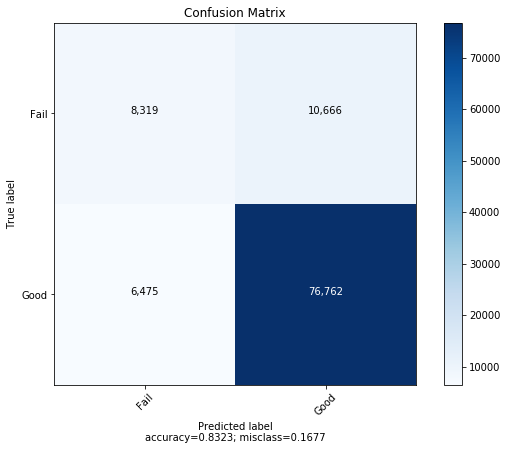

In [106]:
plot_confusion_matrix(cm = sklearn.metrics.confusion_matrix(TEST_y, predicciones_test), 
                      normalize    = False,
                      target_names = ['Fail', 'Good',],
                      title        = "Confusion Matrix")

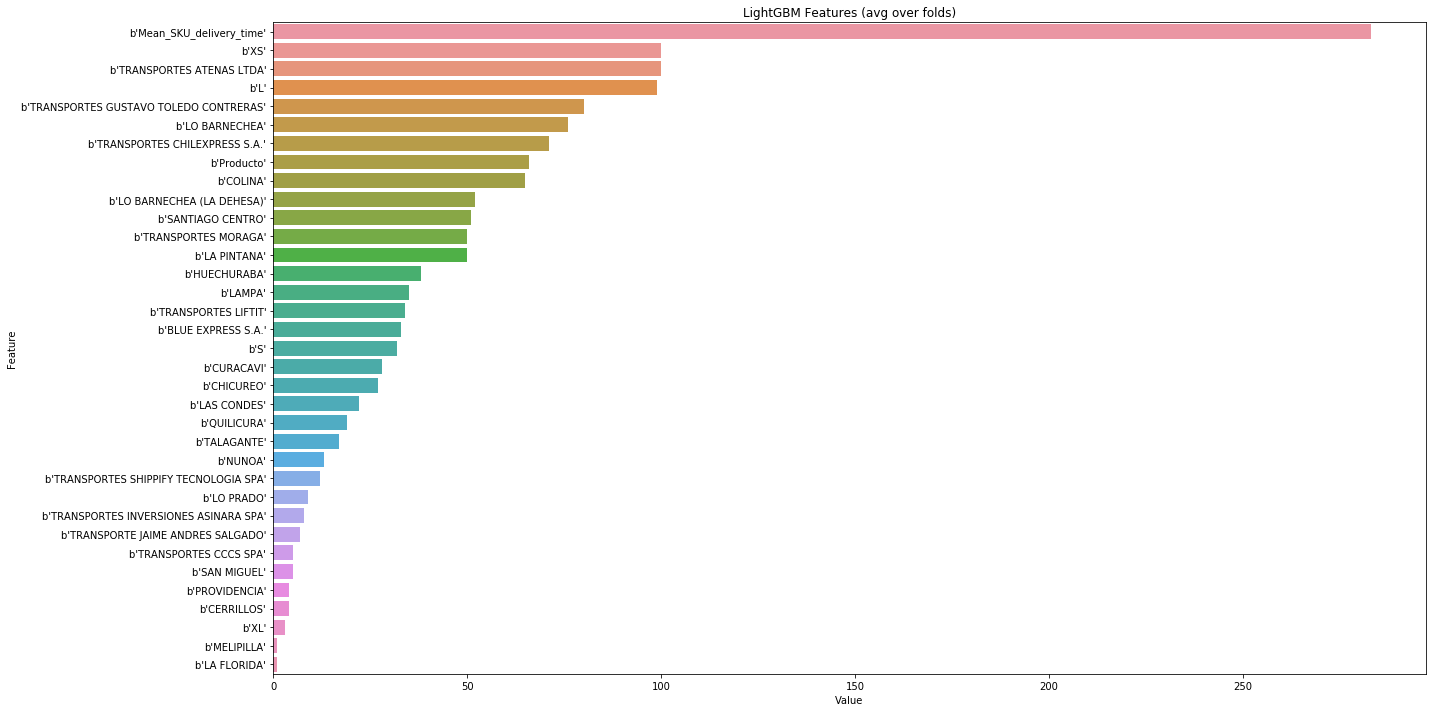

In [107]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_model_I.feature_importances_,x.columns)), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp['Value'] != 0]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## LIGHTGBM (lr=0.01, n_estimators=100, max_depth=4)

In [108]:
lgb_model_I =  lgb.LGBMClassifier(random_state=42, scale_pos_weight=escala, max_depth=4, learning_rate=0.01, n_estimators = 100)

lgb_model_I.fit(train_x,train_y)

predicciones_test= lgb_model_I.predict(TEST_x)

In [109]:
get_metricas(TEST_y, predicciones_test)

Recall: 0.922
Accuracy: 0.832
AUC: 0.68
Matthews correlation coefficient: 0.398


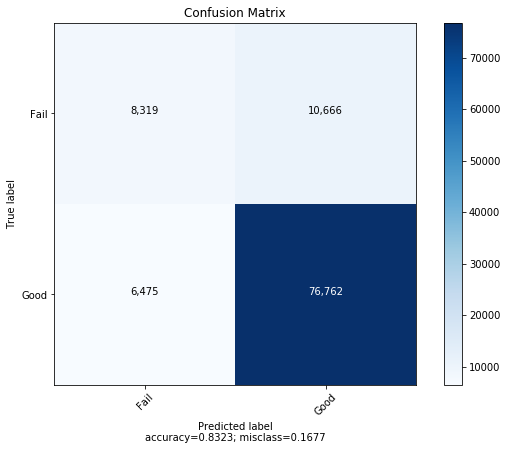

In [110]:
plot_confusion_matrix(cm = sklearn.metrics.confusion_matrix(TEST_y, predicciones_test), 
                      normalize    = False,
                      target_names = ['Fail', 'Good',],
                      title        = "Confusion Matrix")

## Filtrando por las importancias de los features

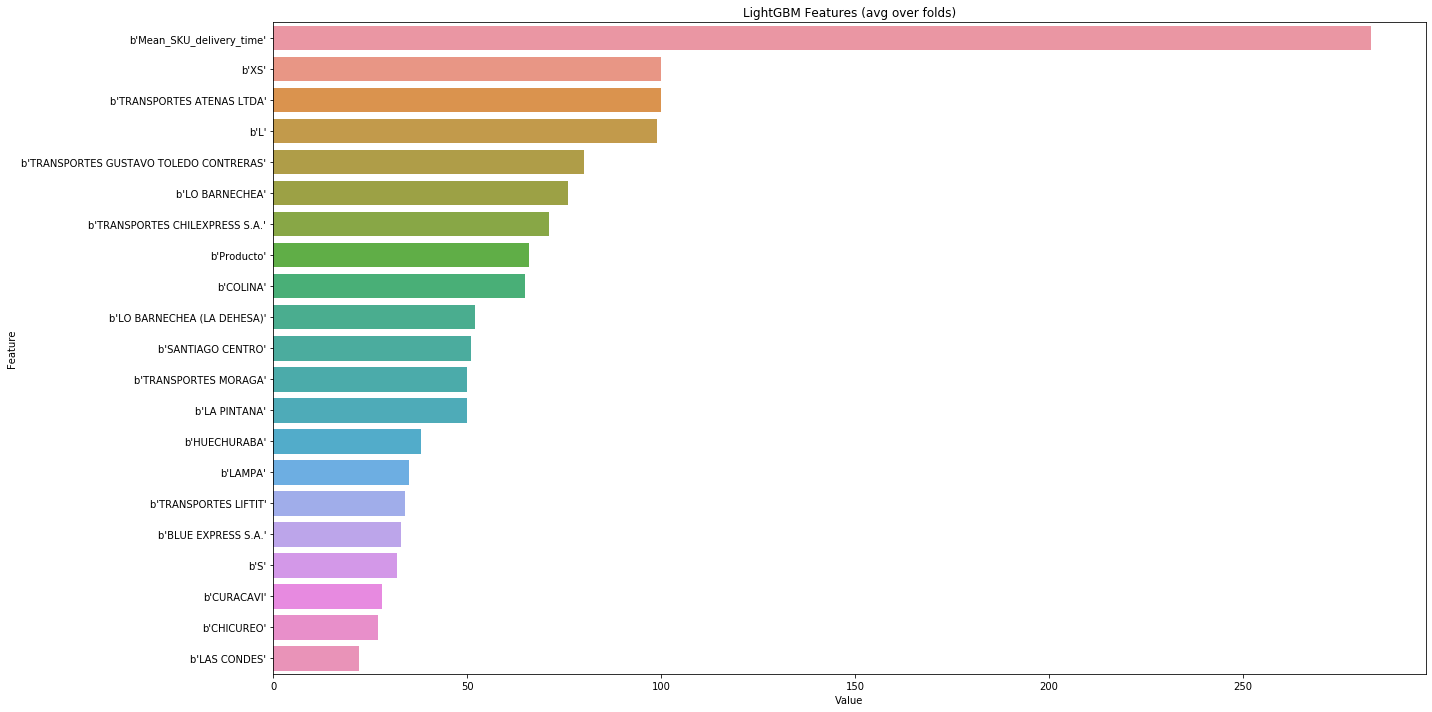

In [111]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_model_I.feature_importances_,x.columns)), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp['Value'] > 20]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Dejando solo los features con mayor importancia

In [112]:
rated_features = feature_imp['Feature'].to_list()

In [113]:
x = df_final.loc[:, rated_features]

In [114]:
y = df_final.iloc[:, 0]

In [115]:
train_x, TEST_x, train_y, TEST_y = train_test_split(x, y, stratify=y
                            , test_size = 0.3, random_state=33)

escala= len(train_y[train_y==0])/len(train_y[train_y==1])

## Lightgbm con los features mas importantes

In [116]:
lgb_model_I =  lgb.LGBMClassifier(random_state=42, scale_pos_weight=escala, max_depth=4, learning_rate=0.01, n_estimators = 100)

lgb_model_I.fit(train_x,train_y)

predicciones_test= lgb_model_I.predict(TEST_x)

In [117]:
get_metricas(TEST_y, predicciones_test)

Recall: 0.922
Accuracy: 0.832
AUC: 0.68
Matthews correlation coefficient: 0.399


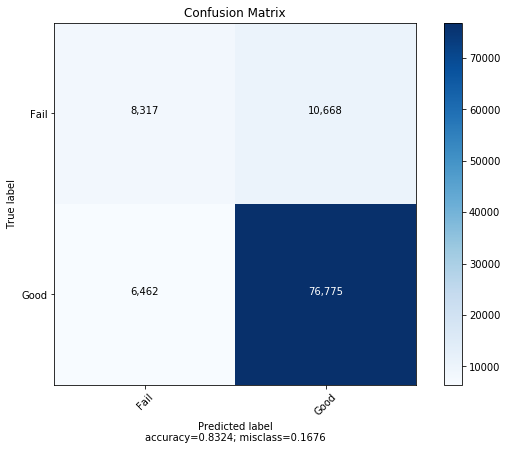

In [118]:
plot_confusion_matrix(cm = sklearn.metrics.confusion_matrix(TEST_y, predicciones_test), 
                      normalize    = False,
                      target_names = ['Fail', 'Good',],
                      title        = "Confusion Matrix")

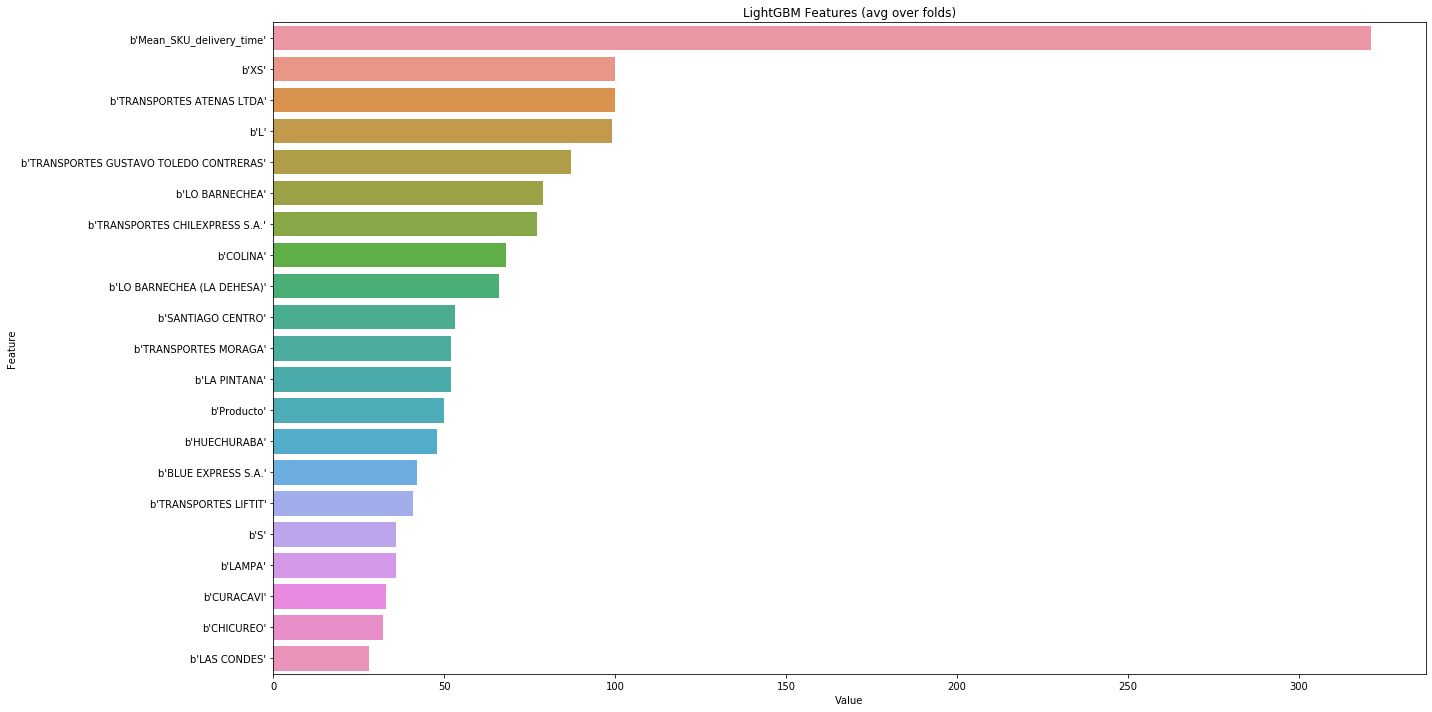

In [119]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_model_I.feature_importances_,x.columns)), columns=['Value','Feature'])
feature_imp = feature_imp[feature_imp['Value'] != 0]

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## Gaussian Naive Bayes

In [120]:
from sklearn.naive_bayes import GaussianNB

In [124]:
gnb = GaussianNB()
y_pred = gnb.fit(train_x, train_y).predict(TEST_x)

In [125]:
get_metricas(TEST_y, y_pred)

Recall: 0.938
Accuracy: 0.827
AUC: 0.638
Matthews correlation coefficient: 0.339


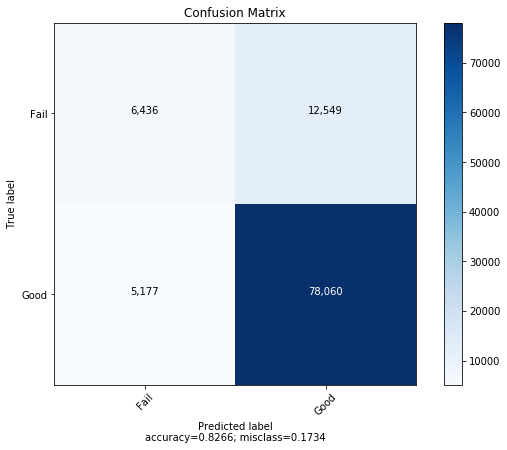

In [126]:
plot_confusion_matrix(cm = sklearn.metrics.confusion_matrix(TEST_y, y_pred), 
                      normalize    = False,
                      target_names = ['Fail', 'Good',],
                      title        = "Confusion Matrix")

## Support Vector Machine

In [127]:
from sklearn import svm

In [ ]:
clf = svm.SVC()
y_pred = clf.fit(train_x, train_y).predict(TEST_x)

In [125]:
get_metricas(TEST_y, y_pred)

Recall: 0.938
Accuracy: 0.827
AUC: 0.638
Matthews correlation coefficient: 0.339


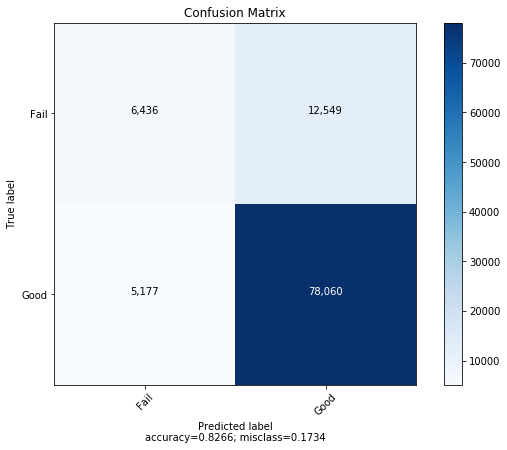

In [126]:
plot_confusion_matrix(cm = sklearn.metrics.confusion_matrix(TEST_y, y_pred), 
                      normalize    = False,
                      target_names = ['Fail', 'Good',],
                      title        = "Confusion Matrix")